In [1]:
#!pip install kaggle

In [2]:
#Importing libraries
import librosa
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, cohen_kappa_score
from itertools import cycle
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder

# Importing data from kaggle api

In [4]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d piyushagni5/berlin-database-of-emotional-speech-emodb

Dataset URL: https://www.kaggle.com/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb
License(s): copyright-authors
 95% 36.0M/38.0M [00:02<00:00, 24.6MB/s]
100% 38.0M/38.0M [00:02<00:00, 17.2MB/s]


In [7]:
!unzip berlin-database-of-emotional-speech-emodb.zip

Archive:  berlin-database-of-emotional-speech-emodb.zip
  inflating: wav/03a01Fa.wav         
  inflating: wav/03a01Nc.wav         
  inflating: wav/03a01Wa.wav         
  inflating: wav/03a02Fc.wav         
  inflating: wav/03a02Nc.wav         
  inflating: wav/03a02Ta.wav         
  inflating: wav/03a02Wb.wav         
  inflating: wav/03a02Wc.wav         
  inflating: wav/03a04Ad.wav         
  inflating: wav/03a04Fd.wav         
  inflating: wav/03a04Lc.wav         
  inflating: wav/03a04Nc.wav         
  inflating: wav/03a04Ta.wav         
  inflating: wav/03a04Wc.wav         
  inflating: wav/03a05Aa.wav         
  inflating: wav/03a05Fc.wav         
  inflating: wav/03a05Nd.wav         
  inflating: wav/03a05Tc.wav         
  inflating: wav/03a05Wa.wav         
  inflating: wav/03a05Wb.wav         
  inflating: wav/03a07Fa.wav         
  inflating: wav/03a07Fb.wav         
  inflating: wav/03a07La.wav         
  inflating: wav/03a07Nc.wav         
  inflating: wav/03a07Wc.wav    

In [8]:
print("Current directory contents:")
print(os.listdir('.'))

Current directory contents:
['.config', 'kaggle.json', 'berlin-database-of-emotional-speech-emodb.zip', 'wav', 'sample_data']


In [9]:
data_dir = './wav'  # Adjust this path to where the data has been extracted
file_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]
print("Example file paths:", file_paths[:5])

Example file paths: ['./wav/13b09Ec.wav', './wav/12a01Wc.wav', './wav/08b02Wd.wav', './wav/16b01Tb.wav', './wav/10a07Wb.wav']


# Creating Dataframe

In [10]:
# Creating a list of the class of each audio file
emotion = [l[-6] for l in file_paths]
emotion[:3]

['E', 'W', 'W']

In [11]:
# Combining the two to make a DataFrame
df = pd.DataFrame(data = {'Audio Path': file_paths, 'Emotion':emotion})

In [12]:
df.head()

,Audio Path,Emotion
0,./wav/13b09Ec.wav,E
1,./wav/12a01Wc.wav,W
2,./wav/08b02Wd.wav,W
3,./wav/16b01Tb.wav,T
4,./wav/10a07Wb.wav,W


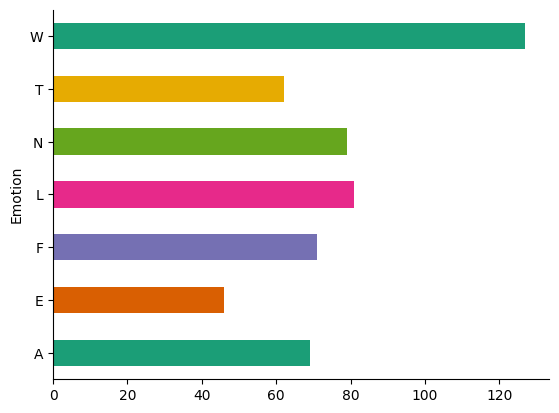

In [13]:
# Checking the number of instances of each class
df.groupby('Emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### The character thats one before the last is what determines the class (or the emotion) of that audio file
W = Anger <br>
L = Boredom <br>
E = Disgust <br>
A = Anxiety/Fear <br>
F = Happiness <br>
T = Sadness <br>
N = Neutral

In [14]:
# Creating a key value pair for each class symbol to its emotion
emo_dict = {'W':'Anger', 'L':"Bordom", 'E':'Disgust', 'A':'Fear', 'F':'Happiness', 'T':'Sadness', 'N':'Neutral'}

# Converting the Emotion Class to a more interpretable form
df['Emotion'] = df['Emotion'].map(emo_dict)

df.head()

,Audio Path,Emotion
0,./wav/13b09Ec.wav,Disgust
1,./wav/12a01Wc.wav,Anger
2,./wav/08b02Wd.wav,Anger
3,./wav/16b01Tb.wav,Sadness
4,./wav/10a07Wb.wav,Anger


In [15]:
# Example audio

ex_audio, sr = librosa.load(df['Audio Path'][0] ,sr = 16000)

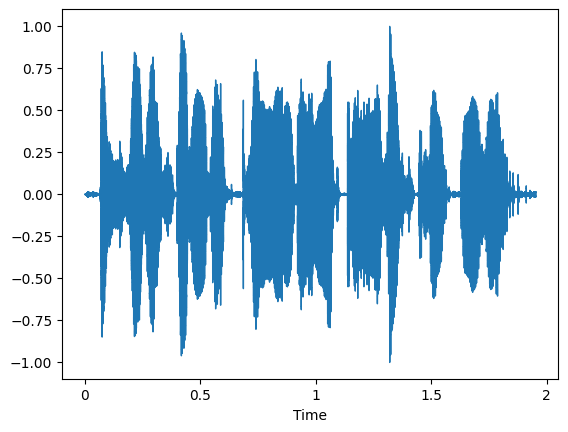

In [16]:
librosa.display.waveshow((ex_audio))

# Extracting features from wav file

In [17]:
# Defining a method for extracting MFCC feture from audio
def get_mfcc(audio_path):
  audio, sr = librosa.load(audio_path, sr = 16000)
  mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=18)
  mfcc_mean = np.mean(mfcc, axis=1)
  return mfcc_mean

In [18]:
# Creating a new column with the new Feature
df['Mfcc'] = df['Audio Path'].apply(get_mfcc)

In [19]:
df.head()

,Audio Path,Emotion,Mfcc
0,./wav/13b09Ec.wav,Disgust,"[-151.49257, 82.45223, 13.255033, 42.10716, 5...."
1,./wav/12a01Wc.wav,Anger,"[-222.02739, 55.874287, -39.689247, 18.096632,..."
2,./wav/08b02Wd.wav,Anger,"[-213.65825, 46.60216, -20.288828, -2.9009867,..."
3,./wav/16b01Tb.wav,Sadness,"[-239.94751, 41.862633, 11.711275, 39.24546, 8..."
4,./wav/10a07Wb.wav,Anger,"[-234.65758, 45.02532, -17.6662, 19.320023, -2..."


# Data Prep

In [21]:
# Creating X and y
X = df['Mfcc']
y = df['Emotion']

X = np.stack(X)

In [22]:
X.shape

(535, 18)

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(428, 18)
(107, 18)
(428,)
(107,)


In [24]:
# Scaling the data
scalar = StandardScaler()
X_train_sc = scalar.fit_transform(X_train)
X_test_sc = scalar.transform(X_test)

In [25]:
# Checking the shape of data
print(X_train_sc.shape)
print(X_test_sc.shape)

(428, 18)
(107, 18)


In [26]:
# Create a label encoder object
encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = encoder.fit_transform(y_train)

# Transform the test labels
y_test_encoded = encoder.transform(y_test)

# Model Building

In [27]:
# Creating a function for evaluating the model

def evaluate_model(y_pred, y_test):
    # Basic evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Detailed report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # ROC Curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y_test))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred, pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

## Logistic Regression

In [34]:
# Creating Logistic regression model
logres = LogisticRegression(max_iter=1000)

# FItting the data
logres.fit(X_train_sc, y_train_encoded)

# Making preductions
y_pred_log_en = logres.predict(X_test_sc)

# Converting the encoded lables to its string lables
y_pred_log = encoder.inverse_transform(y_pred_log_en)

### Evaluation

Accuracy: 0.7009345794392523

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.33      0.64      0.44        11
           2       0.58      0.70      0.64        10
           3       0.73      0.57      0.64        14
           4       0.79      0.73      0.76        15
           5       0.85      0.52      0.65        21
           6       0.67      0.73      0.70        11

    accuracy                           0.70       107
   macro avg       0.70      0.69      0.68       107
weighted avg       0.75      0.70      0.71       107



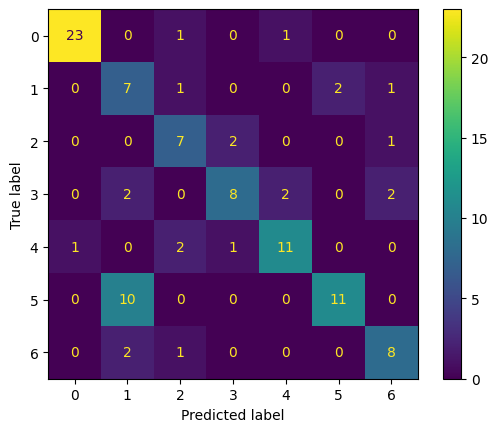

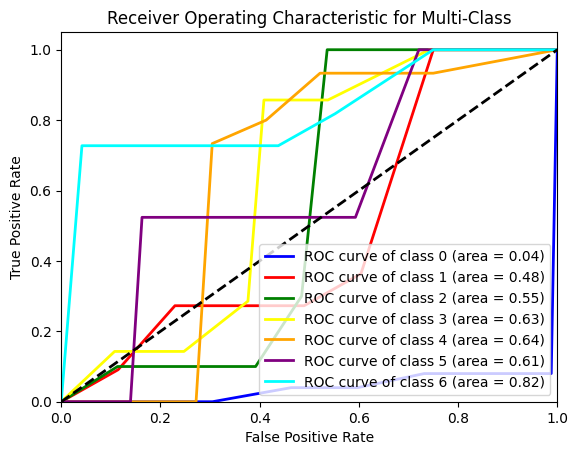

In [37]:
evaluate_model(y_pred_log_en, y_test_encoded)

## Neural Networks

### Without early stop and callbacks

In [38]:
# Defining the model structure
model=Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train_sc.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2432      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [39]:
# Fitting the model
history = model.fit(
    X_train_sc, y_train_encoded,
    epochs=60,
    batch_size=32,
    verbose=1)

Epoch 1/60
14/14 [==============================] - 3s 4ms/step - loss: 2.6065 - accuracy: 0.1519
Epoch 2/60
14/14 [==============================] - 0s 4ms/step - loss: 2.2759 - accuracy: 0.2290
Epoch 3/60
14/14 [==============================] - 0s 4ms/step - loss: 1.9762 - accuracy: 0.3248
Epoch 4/60
14/14 [==============================] - 0s 4ms/step - loss: 1.8762 - accuracy: 0.2944
Epoch 5/60
14/14 [==============================] - 0s 4ms/step - loss: 1.7530 - accuracy: 0.3785
Epoch 6/60
14/14 [==============================] - 0s 5ms/step - loss: 1.5900 - accuracy: 0.4042
Epoch 7/60
14/14 [==============================] - 0s 4ms/step - loss: 1.5406 - accuracy: 0.4486
Epoch 8/60
14/14 [==============================] - 0s 5ms/step - loss: 1.4282 - accuracy: 0.4603
Epoch 9/60
14/14 [==============================] - 0s 4ms/step - loss: 1.4072 - accuracy: 0.4556
Epoch 10/60
14/14 [==============================] - 0s 4ms/step - loss: 1.3840 - accuracy: 0.4673
Epoch 11/60
14/14 [

In [41]:
# Making predictions
y_pred_nn_en_v = model.predict(X_test_sc)
# COnverting the probability to a single class
y_pred_nn_en_indices_v = np.argmax(y_pred_nn_en_v, axis=1)
# Converting the encoded lable to its string lable
y_pred_nn_v = encoder.inverse_transform(y_pred_nn_en_indices_v)

4/4 [==============================] - 0s 4ms/step


Accuracy: 0.7009345794392523

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        25
           1       0.35      0.55      0.43        11
           2       0.69      0.90      0.78        10
           3       0.69      0.64      0.67        14
           4       0.60      0.60      0.60        15
           5       0.81      0.62      0.70        21
           6       0.82      0.82      0.82        11

    accuracy                           0.70       107
   macro avg       0.70      0.70      0.69       107
weighted avg       0.73      0.70      0.71       107



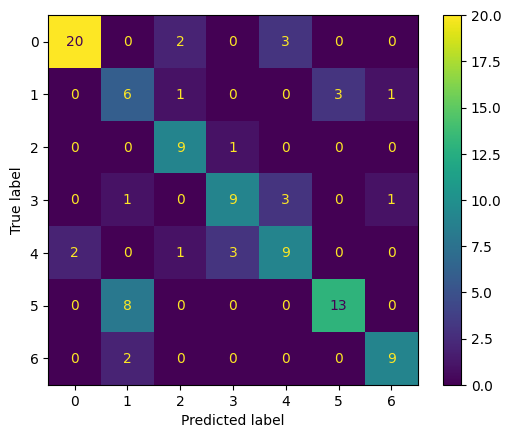

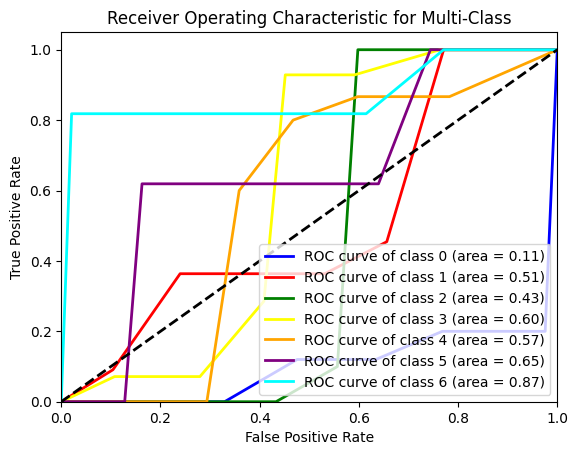

In [43]:
evaluate_model(y_pred_nn_en_indices_v, y_test_encoded)

## Neural Networks 2
### With early stoping and callback

In [44]:
model=Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train_sc.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               2432      
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [45]:
# Defining callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min'
)

# Setup ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='/tmp/best_model.h5',  # Change this to where you want to save the best model
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [46]:
# Fitting the data
history = model.fit(
    X_train_sc, y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[model_checkpoint, early_stopping],  # Include the checkpoint callback here
    verbose=1)

Epoch 1/100
 1/11 [=>............................] - ETA: 31s - loss: 2.8276 - accuracy: 0.1875
Epoch 1: val_accuracy improved from -inf to 0.15116, saving model to /tmp/best_model.h5
11/11 [==============================] - 4s 43ms/step - loss: 2.7562 - accuracy: 0.1550 - val_loss: 1.9382 - val_accuracy: 0.1512
Epoch 2/100
 1/11 [=>............................] - ETA: 0s - loss: 2.5323 - accuracy: 0.2500
Epoch 2: val_accuracy improved from 0.15116 to 0.23256, saving model to /tmp/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 0s 14ms/step - loss: 2.4928 - accuracy: 0.2047 - val_loss: 1.8876 - val_accuracy: 0.2326
Epoch 3/100
 1/11 [=>............................] - ETA: 0s - loss: 2.4779 - accuracy: 0.1562
Epoch 3: val_accuracy improved from 0.23256 to 0.30233, saving model to /tmp/best_model.h5
11/11 [==============================] - 0s 14ms/step - loss: 2.2380 - accuracy: 0.2281 - val_loss: 1.8376 - val_accuracy: 0.3023
Epoch 4/100
 1/11 [=>............................] - ETA: 0s - loss: 2.1554 - accuracy: 0.3125
Epoch 4: val_accuracy improved from 0.30233 to 0.34884, saving model to /tmp/best_model.h5
11/11 [==============================] - 0s 14ms/step - loss: 2.1207 - accuracy: 0.2485 - val_loss: 1.7942 - val_accuracy: 0.3488
Epoch 5/100
 1/11 [=>............................] - ETA: 0s - loss: 1.6106 - accuracy: 0.3750
Epoch 5: val_accuracy improved from 0.34884 to 0.39535, saving model to /tmp/best_model.h5
11/11 [==============================] - 0s 12ms/ste

In [47]:
# Loading the model with best weights
model.load_weights('/tmp/best_model.h5')

In [48]:
# Making predictions
y_pred_nn_en = model.predict(X_test_sc)
# Converting probability to a single class
y_pred_nn_en_indices = np.argmax(y_pred_nn_en, axis=1)
# COnverting encoded lable to its string form
y_pred_nn = encoder.inverse_transform(y_pred_nn_en_indices)

4/4 [==============================] - 0s 5ms/step


Accuracy: 0.7383177570093458

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        25
           1       0.40      0.55      0.46        11
           2       0.69      0.90      0.78        10
           3       0.77      0.71      0.74        14
           4       0.69      0.60      0.64        15
           5       0.81      0.62      0.70        21
           6       0.73      1.00      0.85        11

    accuracy                           0.74       107
   macro avg       0.72      0.75      0.72       107
weighted avg       0.76      0.74      0.74       107



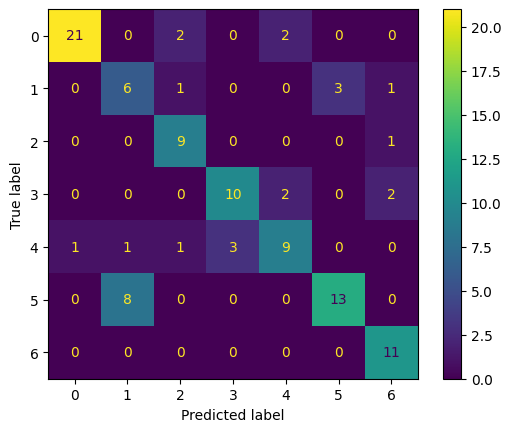

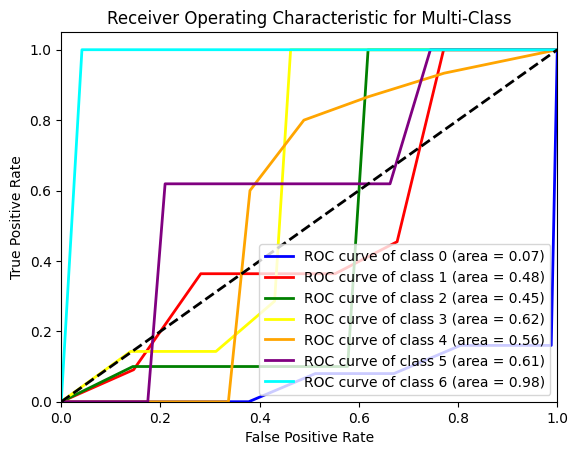

In [49]:
evaluate_model(y_pred_nn_en_indices, y_test_encoded)

## Recurrent Neural Network (RNN)

In [54]:
# Creating a saperate copy of the data frame since the RNN requires changing the shape of the data
X_train_sc_rnn = X_train_sc.copy()
X_test_sc_rnn = X_test_sc.copy()

In [55]:
# Reshape the data to fit the RNN input requirements
X_train_sc_rnn = X_train_sc_rnn.reshape((X_train_sc_rnn.shape[0], 18, 1))
X_test_sc_rnn = X_test_sc_rnn.reshape((X_test_sc_rnn.shape[0], 18, 1))

In [57]:
# Checking the shape of data
print(X_train_sc_rnn.shape)
print(X_test_sc_rnn.shape)

(428, 18, 1)
(107, 18, 1)


In [61]:
# Building model

model = Sequential()
model.add(SimpleRNN(64, input_shape=(18,1), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 7)                 455       
                                                                 
Total params: 8839 (34.53 KB)
Trainable params: 8839 (34.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# Defining Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min'
)

# Setup ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='/tmp/best_rnn_model.h5',  # Change this to where you want to save the best model
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [63]:
# Fitting the model
history = model.fit(
    X_train_sc_rnn, y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[model_checkpoint, early_stopping],  # Include the checkpoint callback here
    verbose=1)

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.9216 - accuracy: 0.1725 
Epoch 1: val_accuracy improved from -inf to 0.26744, saving model to /tmp/best_rnn_model.h5
11/11 [==============================] - 2s 41ms/step - loss: 1.9216 - accuracy: 0.1725 - val_loss: 1.8612 - val_accuracy: 0.2674
Epoch 2/100
 1/11 [=>............................] - ETA: 0s - loss: 1.8521 - accuracy: 0.2812
Epoch 2: val_accuracy improved from 0.26744 to 0.30233, saving model to /tmp/best_rnn_model.h5
11/11 [==============================] - 0s 11ms/step - loss: 1.8306 - accuracy: 0.2398 - val_loss: 1.6914 - val_accuracy: 0.3023
Epoch 3/100
 1/11 [=>............................] - ETA: 0s - loss: 1.6469 - accuracy: 0.2812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/11 [==========================>...] - ETA: 0s - loss: 1.6838 - accuracy: 0.2562
Epoch 3: val_accuracy improved from 0.30233 to 0.40698, saving model to /tmp/best_rnn_model.h5
11/11 [==============================] - 0s 12ms/step - loss: 1.6704 - accuracy: 0.2602 - val_loss: 1.5521 - val_accuracy: 0.4070
Epoch 4/100
 1/11 [=>............................] - ETA: 0s - loss: 1.5933 - accuracy: 0.5000
Epoch 4: val_accuracy improved from 0.40698 to 0.45349, saving model to /tmp/best_rnn_model.h5
11/11 [==============================] - 0s 13ms/step - loss: 1.4930 - accuracy: 0.4094 - val_loss: 1.3988 - val_accuracy: 0.4535
Epoch 5/100
 9/11 [=======================>......] - ETA: 0s - loss: 1.3105 - accuracy: 0.4896
Epoch 5: val_accuracy improved from 0.45349 to 0.52326, saving model to /tmp/best_rnn_model.h5
11/11 [==============================] - 0s 14ms/step - loss: 1.3106 - accuracy: 0.4854 - val_loss: 1.2494 - val_accuracy: 0.5233
Epoch 6/100
 7/11 [==================>...........] -

In [64]:
# Making predictions
y_pred_rnn = model.predict(X_test_sc_rnn)

4/4 [==============================] - 0s 4ms/step


In [67]:
# Converting probability to a single class
y_pred_rnn_indices = np.argmax(y_pred_rnn, axis=1)
# Converting encoded lable to its string form
y_pred_rnnn = encoder.inverse_transform(y_pred_rnn_indices)

Accuracy: 0.5700934579439252

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.68      0.76        25
           1       0.32      0.73      0.44        11
           2       0.53      0.80      0.64        10
           3       0.50      0.14      0.22        14
           4       0.47      0.47      0.47        15
           5       0.60      0.43      0.50        21
           6       0.77      0.91      0.83        11

    accuracy                           0.57       107
   macro avg       0.58      0.59      0.55       107
weighted avg       0.61      0.57      0.56       107



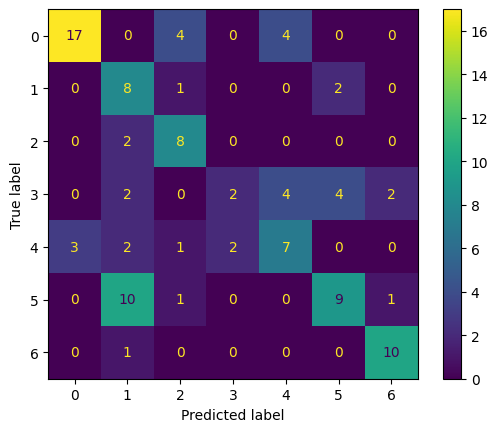

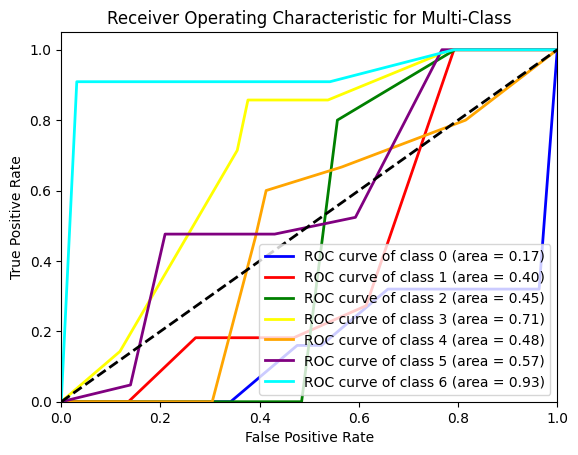

In [70]:
evaluate_model(y_pred_rnn_indices, y_test_encoded)